<a href="https://colab.research.google.com/github/ameasure/colab_tutorials/blob/master/FastAI%201.0.50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the prerequisites

1.   pytorch (a library for building neural networks)
2.   fastai (a library on top of pytorch)
3.   spacy english language model
4.   msha.xlsx data
5.   xlrd (a library to read excel files)

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai
!python -m spacy download en
!wget --no-clobber 'https://github.com/ameasure/autocoding-class/raw/master/msha.xlsx'
!pip install xlrd

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

File ‘msha.xlsx’ already there; not retrieving.



In [2]:
import pandas as pd

df = pd.read_excel('msha.xlsx')
df['ACCIDENT_YEAR'] = df['ACCIDENT_DT'].apply(lambda x: x.year)
df['ACCIDENT_YEAR'].value_counts()
df_train = df[df['ACCIDENT_YEAR'].isin([2010, 2011])].copy()
df_valid = df[df['ACCIDENT_YEAR'] == 2012].copy()
print('training rows:', len(df_train))
print('validation rows:', len(df_valid))

training rows: 18681
validation rows: 9032


In [0]:
from sklearn.preprocessing import LabelEncoder

labeler = LabelEncoder().fit(df['INJ_BODY_PART'])
df_train['LABEL'] = labeler.transform(df_train['INJ_BODY_PART'])
df_valid['LABEL'] = labeler.transform(df_valid['INJ_BODY_PART'])

FastAI is very picky (in a pretty ridiculous way) about the data formats it accepts. We save the training and validation data in this way to meet FastAI requirements for using csv files. Specifically, FastAI requires:

1.   The first column must contain the label
2.   The second column must contain the text
3.   The CSV must not have a header (column names at the top)


In [4]:
df_train[['LABEL', 'NARRATIVE']].to_csv('train.csv', header=False, index=False)
df_valid[['LABEL', 'NARRATIVE']].to_csv('valid.csv', header=False, index=False)
n_labels = len(labeler.classes_)
print(n_labels)

46


In [0]:
from fastai.text.data import TextLMDataBunch

Create a "DataBunch" from our CSV files. A "DataBunch" contains tokenized text that has been mapped to numbers, each representing a word in the text.

In [0]:
lm_data = TextLMDataBunch.from_df('./', 
                                  text_cols=['NARRATIVE'],
                                   train_df=df_train,
                                   valid_df=df_valid)

We are going to use a pretrained language model to build a state of the art text classifier. This involves the following steps:

1.   Load the weights for a pre-trained language model, i.e. a model trained on a huge collection of text. We don't want to do this ourselves because it takes a huge amount of time.
2.   Finetune the language model to some of the language data in our dataset. This can include all the data currently available since this is an unsupervised process.
3.   Cut off the language model output layer and put a classifier layer on top.
4.   Finetune the new model to our classification task




# Load the pretrained model weights

We create a directory called 'models', and download them there.

In [0]:
import os

if not os.path.exists('models'):
  os.mkdir('models')

Download the pretrained models

In [0]:
from fastai.core import download_url

download_url('http://files.fast.ai/models/wt103_v1/lstm_wt103.pth', 'models/lstm_wt103.pth')
download_url('http://files.fast.ai/models/wt103_v1/itos_wt103.pkl', 'models/itos_wt103.pkl')

# Finetune the language model on some of our own text

We start by preparing a "language model" DataBunch of some of our data. This is just data that's in a format useful for language modelling.

Load the model and finetune it on our data for 1 epoch.

In [51]:
from fastai.text.learner import language_model_learner
from fastai.text.models import AWD_LSTM

language_model = language_model_learner(lm_data, 
                                        arch=AWD_LSTM,
                                        pretrained_fnames=['lstm_wt103', 'itos_wt103'], 
                                        drop_mult=0.5)
language_model.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.934488,3.598390,0.331491,01:14


In [52]:
language_model.unfreeze()
language_model.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.537934,3.357045,0.361825,01:32
1,3.295383,3.173529,0.382923,01:31
2,3.152932,3.089895,0.392817,01:32
3,3.043761,3.049821,0.397758,01:31
4,2.992951,3.045159,0.398295,01:32


In [0]:
language_model.save_encoder('ft_enc')

# Fit the model to our classification task

In [0]:
#!wget --no-clobber https://www.dropbox.com/s/45i662vci7ja6vv/ft_enc.pth?dl=0
#!mv ft_enc.pth?dl=0 models/ft_enc.pth

In [0]:
from fastai.text import TextClasDataBunch

data_clas = TextClasDataBunch.from_df('./', 
                                      train_df = df_train, 
                                      valid_df = df_valid,
                                      text_cols=['NARRATIVE'],
                                      label_cols=['LABEL'],
                                      classes=sorted(df_train['LABEL'].unique()),
                                      vocab=lm_data.train_ds.vocab)

In [55]:
data_clas.show_batch()

text,target
"xxbos xxup ee xxup was xxup removing xxup wheel xxup chocks w / l xxup hand xxup out xxup from xxup under l xxup front xxup wheel xxup of xxup truck . xxup as xxup he xxup pulled xxup rope & xxup twisted xxup chocks xxup for xxup removal , xxup felt xxup pain xxup in xxup top xxup of l xxup hand . xxup ee xxup refused xxup medical",45
"xxbos xxup end xxup of xxup shift , xxup employee xxup parked xxup the xxup xxunk xxup excavator , xxup was xxup dismounting xxup from xxup equipment . xxup foot xxup caught xxup on xxup door xxup frame & xxup causing xxup him xxup to xxup loose xxup balance xxup and xxup slip / xxup fall . xxup left xxup hand xxup gripping xxup hand xxup rail - xxup caught",35
"xxbos xxup employee xxup was xxup unloading xxup salt xxup from a xxup railcar xxup at xxup the xxup unload xxup station . xxup large xxup chunks xxup of xxup salt xxup began xxup to xxup build xxup up xxup in xxup the xxup unload xxup chute . xxup employee xxup used a 1 / 2 "" xxup pipe xxup in xxup an xxup attempt xxup to xxup dislodge xxup",16
"xxbos xxup while xxup grinding , a xxup small xxup spec xxup of xxup metal xxup fell xxup into xxup employee xxup 's xxup right xxup eye . xxup after xxup seen xxup by a xxup physician xxup the xxup metal xxup was xxup removed . xxup employee xxup was xxup given xxup eye xxup drops xxup and xxup returned xxup to xxup work xxup the xxup next xxup day",13
"xxbos xxup removing a xxup hydraulic xxup pump xxup on xxup xxunk . xxup he xxup reached xxup up xxup to xxup start xxup removing a xxup hose xxup clamp and xxup got xxup some xxup dirt xxup in xxup his xxup face , xxup he xxup brushed xxup the xxup dirt xxup away , xxup continued xxup to xxup work . xxup ee xxup was xxup at xxup lunch",13


In [0]:
from fastai.text.learner import text_classifier_learner

learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

We can use the `lr_find()` tool to find a good learning rate to use. It shows how rapidly the loss changes at various learning rates, generally you want the learning rate that gives the steepest drop in loss. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


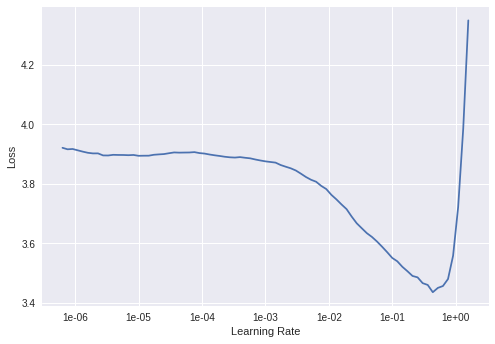

In [57]:
learn.lr_find()
learn.recorder.plot()

We now fit our classifier to the data, first only the last layer, then unfreezing the lower layers until the whole model is being trained.

In [58]:
# Fit just the last layer of the model
learn.fit_one_cycle(1, 1e-1)
# Now unfreeze the last 2 layers and fit those
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.428555,2.063200,0.425266,00:49


epoch,train_loss,valid_loss,accuracy,time
0,1.896905,1.537198,0.563995,00:59


In [59]:
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.791938,1.524086,0.590567,00:56


In [0]:
# Unfreeze all layers and fit these
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.682792,1.517549,0.617914,01:53
1,1.473120,1.074947,0.705492,01:54
2,1.313984,0.966731,0.736935,01:59


In [0]:
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))